# Exploratory Data Analysis (EDA)

- **Creation Date**: June 13, 2025  
- **Author**: Corentin Vasseur — [vasseur.corentin@gmail.com](mailto:vasseur.corentin@gmail.com)

---

This notebook provides an initial exploration of the dataset to better understand its structure, key patterns, and potential data quality issues. 

We examine the distribution of key features, relationships between variables, and identify anomalies or inconsistencies that may affect downstream modeling. 

This step helps inform preprocessing strategies and feature engineering decisions.


# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from skrub import GapEncoder
from skrub import Cleaner, TableReport

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import sys
sys.path.append('../src/')
from qto_categorizer_ml.io.datasets import CSVReader
from qto_categorizer_ml.io.services import LoggerService

logger = LoggerService().logger()

# Nombre de transaction baisse en fin d'année 2024 

## 2. Load datasets

The provided dataset is real and anonymized. Each customer represents a potential Qonto client, meaning they are professional businesses (SMEs, freelancers…). The clients are independent of each other, each with their own business.

Each row in the dataset represents a transaction, and each transaction is associated with a category.

| **Column**  | **Description** |
| --- | --- |
| **TRANSACTION_ID** | Unique identifier for the transaction |
| **DATE_EMITTED** | Emission date of the transaction |
| **AMOUNT** | Transaction amount in EUR |
| **TYPE_OF_PAYMENT** | Can be Credit Card, Transfer, Direct Debit…  |
| **MERCHANT_NAME** | Name of the merchant. |
| **DESCRIPTION** | Transaction description (can be empty) |
| **SIDE** | If the transaction is credit or debit. (credit: 1, debit: 0) |
| **CATEGORY** | The assigned category (this is what we want to predict) |

In [2]:
dtypes = {
    'TRANSACTION_ID': str,
    'AMOUNT': float,
    'TYPE_OF_PAYMENT': str,
    'MERCHANT_NAME': str,
    'DESCRIPTION': str,
    'SIDE':  int,
    'CATEGORY': str,
}

parse_dates = ['DATE_EMITTED']

path = "../data/data-products.csv"
df = CSVReader(path=path, dtypes=dtypes, parse_dates=parse_dates).read()

logger.info(
    f"Number of transactions: {df.TRANSACTION_ID.shape[0]}, "
    "are unique? {df.TRANSACTION_ID.shape[0]==df.TRANSACTION_ID.unique().shape[0]}"
)

df[['AMOUNT', 'TYPE_OF_PAYMENT', 'MERCHANT_NAME', 'DESCRIPTION', 'CATEGORY']].head()

2025-06-13 22:42:57.625 | INFO     | __main__:<module>:16 - Number of transactions: 337237, are unique? {df.TRANSACTION_ID.shape[0]==df.TRANSACTION_ID.unique().shape[0]}


,AMOUNT,TYPE_OF_PAYMENT,MERCHANT_NAME,DESCRIPTION,CATEGORY
0,2187.72,Transfer,FACILECOMM,PRLV FACILECOMM SAS 2414822G10219163,Bank Fees & Charges: Subscription Fees
1,4.94,Direct Debit,GOOGLE CLOUD FRANCE,PRLV SEPA GOOGLE CLOUD FRANCE S GG103JLMOS CLO...,Technology Expenses: Hosting Services
2,3.77,Transfer,AMPEVINO,LES VOUTES - FA00003482 - AMPEVINO,Food & Beverage Expenses
3,130.87,Credit Card,LECLERC,NaN,Operational Expenses: Other Operational Expenses
4,4582.19,Direct Debit,LEODIS ACHAT BOISSONS,EFFETS DOMICILIES DOMICILIES,Food & Beverage Expenses


## 3. Table Report

Remarks: 
- The data contains missing values in key categorical features: `TYPE_OF_PAYMENT`, `MERCHANT_NAME`, and `DESCRIPTION`. 
- The `AMOUNT` variable shows extreme values, some exceeding `€4000`, indicating potential `outliers`.
- The `SIDE` variable is unbalanced, containing only category `0`, which corresponds exclusively to `debit` transactions.
- The transaction period spans from `September 1, 2023`, to `September 18, 2024`. The association analysis reveals notable relationships between `TYPE_OF_PAYMENT` and `MERCHANT_NAME`, as well as between `CATEGORY` and both `MERCHANT_NAME` and `TYPE_OF_PAYMENT`, suggesting these features are strongly linked and could be informative for classification.

In [3]:
Cleaner().fit_transform(df)
TableReport(df)

Processing column   8 / 8


,,,,,,,,


## 4. Data Analysis
### 4.1 Unit Data Analysis
#### CATEGORY (target), unbalanced

- The "Income Taxes" class contains only 4 transaction categorization examples. Typically, these transactions are related to DGFIP.
- Other classes have over a hundred transaction examples each.

In [4]:
df.CATEGORY.value_counts().tail()

CATEGORY
Bank Fees & Charges: Loan Repayments    313
Employee Expenses: Salaries             259
Employee Expenses: Pension              181
Taxes: National Insurance               174
Taxes: Income Taxes                       4
Name: count, dtype: int64

#### SIDE 
`SIDE` contains only one unique value (likely all 0s with no examples of value 1), making it uninformative for classification and therefore will be excluded from the feature set.

In [5]:
df.SIDE.value_counts()

SIDE
0    337237
Name: count, dtype: int64

#### TYPE_OF_PAYMENT

This horizontal bar chart shows the distribution of payment types in the dataset, with `Transfer` being the dominant payment method (approximately 200,000 transactions), followed by `Credit Card` (~ 75,000) and `Direct Debit` (~25,000), while other payment methods like `Cash`, `PayPal`, `Check`, and `Bill of Exchange` show minimal.

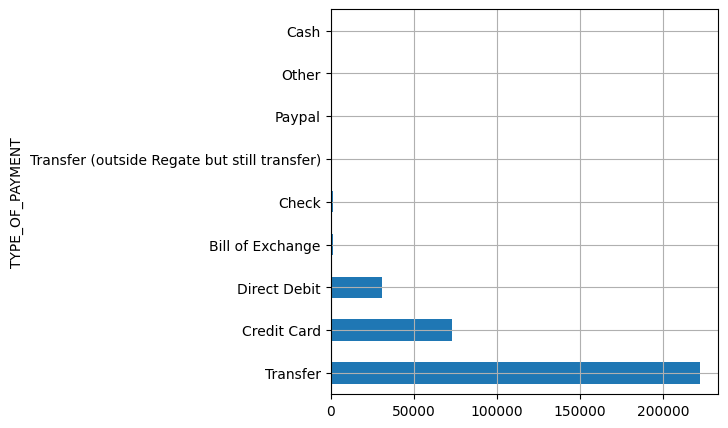

In [6]:
df.TYPE_OF_PAYMENT.value_counts().plot(kind='barh', figsize=(5,5))
plt.grid(True)

#### MERCHANT FEATURE

The overwhelming majority of merchants (~39,000) have a dominant category ratio close to 1.0 (number of CATEGORY), indicating they operate almost exclusively within a single expense category. 

This suggests most merchants are highly specialized businesses with clear, consistent service offerings (e.g., office supply stores, fuel stations, specific restaurants). 

A much smaller subset of merchants shows lower dominance ratios, representing businesses that span multiple categories. 

This distribution supports the modeling approach mentioned in the code comment - using the most frequent category as a baseline predictor for merchant transactions would be highly effective given that most merchants maintain consistent category patterns. The high specialization also validates MERCHANT_NAME as a strong predictive feature for category classification, as the vast majority of merchants have predictable, category-specific transaction patterns.

2025-06-13 22:43:00.957 | INFO     | __main__:<module>:1 - Number of merchant name : 49518


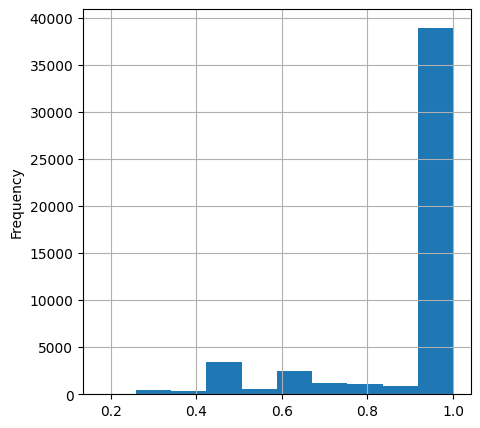

In [7]:
logger.info(f"Number of merchant name : {df.MERCHANT_NAME.unique().shape[0]}")

# Count number of category per marchant
df['MERCHANT_NAME'] = df.MERCHANT_NAME.replace(' ', "NO MARCHENT").fillna('NO MERCHANT')

category_counts = df.groupby(['MERCHANT_NAME', 'CATEGORY']).size().reset_index(name="count")

dominant_ratio = ( 
    category_counts\
        .groupby('MERCHANT_NAME')\
        .apply(lambda x: x['count'].max() / x['count'].sum(), include_groups=False)\
        .reset_index(name='dominant_category_ratio')
)

dominant_ratio.dominant_category_ratio.plot(kind='hist', figsize=(5,5))
plt.grid(True)

#### AMOUNT

The transaction amount distribution shows a highly skewed pattern with 50.2% of transactions under €50 and 90.4% under €4,000, indicating the dataset is dominated by small to medium-value transactions with relatively few high-value outliers.

In [8]:
# 50% des transactions < 50€, 80% <1000, 90% <4000
logger.info(f"""
    % transaction btw 0-20€ {round(df[df['AMOUNT']<20]['AMOUNT'].shape[0]/df.shape[0]*100,1)}%,
    % transaction 0-50€ {round(df[df['AMOUNT']<50]['AMOUNT'].shape[0]/df.shape[0]*100,1)}%, 
    % transaction 0-1000€ {round(df[df['AMOUNT']<1000]['AMOUNT'].shape[0]/df.shape[0]*100,1)}%,
    % transaction 0-4000€ {round(df[df['AMOUNT']<4000]['AMOUNT'].shape[0]/df.shape[0]*100,1)}%
""")

2025-06-13 22:43:02.704 | INFO     | __main__:<module>:2 - 
    % transaction btw 0-20€ 45.1%,
    % transaction 0-50€ 50.2%, 
    % transaction 0-1000€ 79.3%,
    % transaction 0-4000€ 90.4%



#### DATE_EMITTED

**Left Graph - Transaction Volume Trends:**
- The data shows a clear business lifecycle pattern from September 2023 to September 2024. Both transaction count and merchant count follow similar trajectories, starting near zero and experiencing rapid growth through early 2024. The peak activity occurs around May-June 2024, with transaction counts reaching ~1,350 and merchant counts peaking at ~900. Notably, there's a sharp decline beginning in July 2024, with both metrics dropping dramatically by September 2024, suggesting either seasonal effects, business challenges, or data collection period ending.

**Right Graph - Category vs Payment Type Distribution:**
- This reveals an interesting operational characteristic. The category count (likely product/service categories) shows variability throughout the observation period, ranging from 30-42 categories and maintaining relatively stable diversity even during the decline phase. - In contrast, payment type count 5-10 and stable throughout the entire period, indicating a limited but consistent payment infrastructure regardless of transaction volume.

**Scaling relationship: Merchants and transactions scale proportionally**
- Sharp transition: The July 2024 inflection point suggests a significant operational change rather than gradual decline

This pattern could indicate a startup scaling rapidly then facing market challenges, or a seasonal business with a concentrated active period.

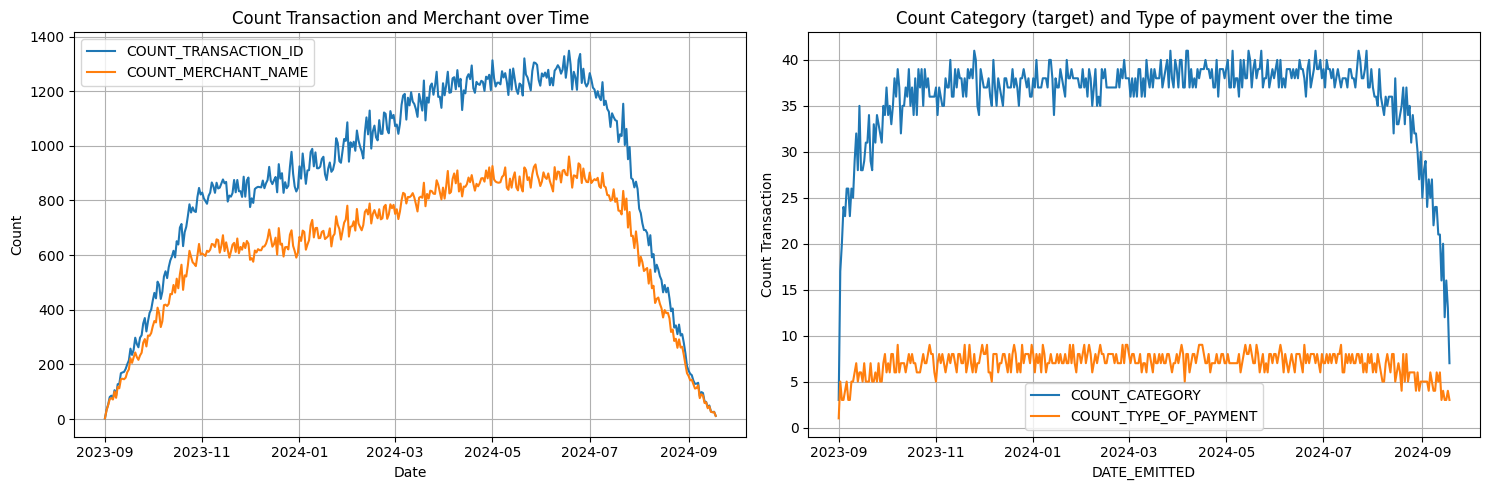

In [9]:
df_grouped_by_year_month = df\
    .groupby(['DATE_EMITTED'])\
    .agg({'TRANSACTION_ID': pd.Series.nunique, 'CATEGORY': pd.Series.nunique, 'TYPE_OF_PAYMENT': pd.Series.nunique, 'MERCHANT_NAME': pd.Series.nunique})\
    .rename(columns={'TRANSACTION_ID': 'COUNT_TRANSACTION_ID', 'CATEGORY': 'COUNT_CATEGORY', 'TYPE_OF_PAYMENT': 'COUNT_TYPE_OF_PAYMENT', 'MERCHANT_NAME': 'COUNT_MERCHANT_NAME'})\
    .reset_index()

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_TRANSACTION_ID'])
ax[0].plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_MERCHANT_NAME']) 
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Count')
ax[0].set_title('Count Transaction and Merchant over Time')
ax[0].legend(['COUNT_TRANSACTION_ID','COUNT_MERCHANT_NAME'])
ax[0].grid(True)

ax[1].plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_CATEGORY']) # number of category change over time (between 40 and 42 category) -> new category or not?
ax[1].plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_TYPE_OF_PAYMENT']) # Cash category doesnot exist in last month Sept 2024
ax[1].set_xlabel('DATE_EMITTED')
ax[1].set_ylabel('Count Transaction')
ax[1].set_title('Count Category (target) and Type of payment over the time')
ax[1].legend(['COUNT_CATEGORY','COUNT_TYPE_OF_PAYMENT'])
ax[1].grid(True)

plt.tight_layout()

In [10]:
#df['YEAR'], df['MONTH'], df['DAY'] = df['DATE_EMITTED'].dt.year, df['DATE_EMITTED'].dt.month, df['DATE_EMITTED'].dt.day
# df['YEAR_MONTH'] = df['YEAR'].astype(str) + df['MONTH'].astype(str)
# Cash category in TYPE_OF_PAYMENT variable doesnot exist in last month Sept 2024
# df[(df.MONTH==9) & (df.YEAR==2023)][['YEAR', 'MONTH','TYPE_OF_PAYMENT']].value_counts()
# df[(df.MONTH==9) & (df.YEAR==2024)][['YEAR', 'MONTH','TYPE_OF_PAYMENT']].value_counts()
# df[(df.YEAR==2024) & (df.MONTH==9)].DATE_EMITTED.sort_values().unique() # 2023 toutes les transaction, en 2024 uniquement jusque 18 septembre (pour le mois de septembre)


### 5. Cross features analysis: Business Expense Category Analysis - Most vs Least Frequent Categories

**Top 5 Most Frequent Categories (Left Charts):** 

Transaction Volume Patterns:
- Production Costs dominate the expense landscape
- Other category follow a similar but more moderate trajectory, peaking around 3,500 transactions
- Food & Beverage, Travel/Transport, and Office Supplies show parallel growth patterns but at much lower volumes (500-3,000 range)

Merchant Distribution:
- The merchant counts reveal a more nuanced story - while Production Costs lead in transaction volume, the merchant distribution is more balanced, suggesting fewer merchants handle higher transaction volumes for production, while operational expenses are spread across more vendors.

**Top 5 Least Frequent Categories (Right Charts):**
- Lower Volume, Higher Variability with `Taxes Incomes Taxes` category only appears between November and July.

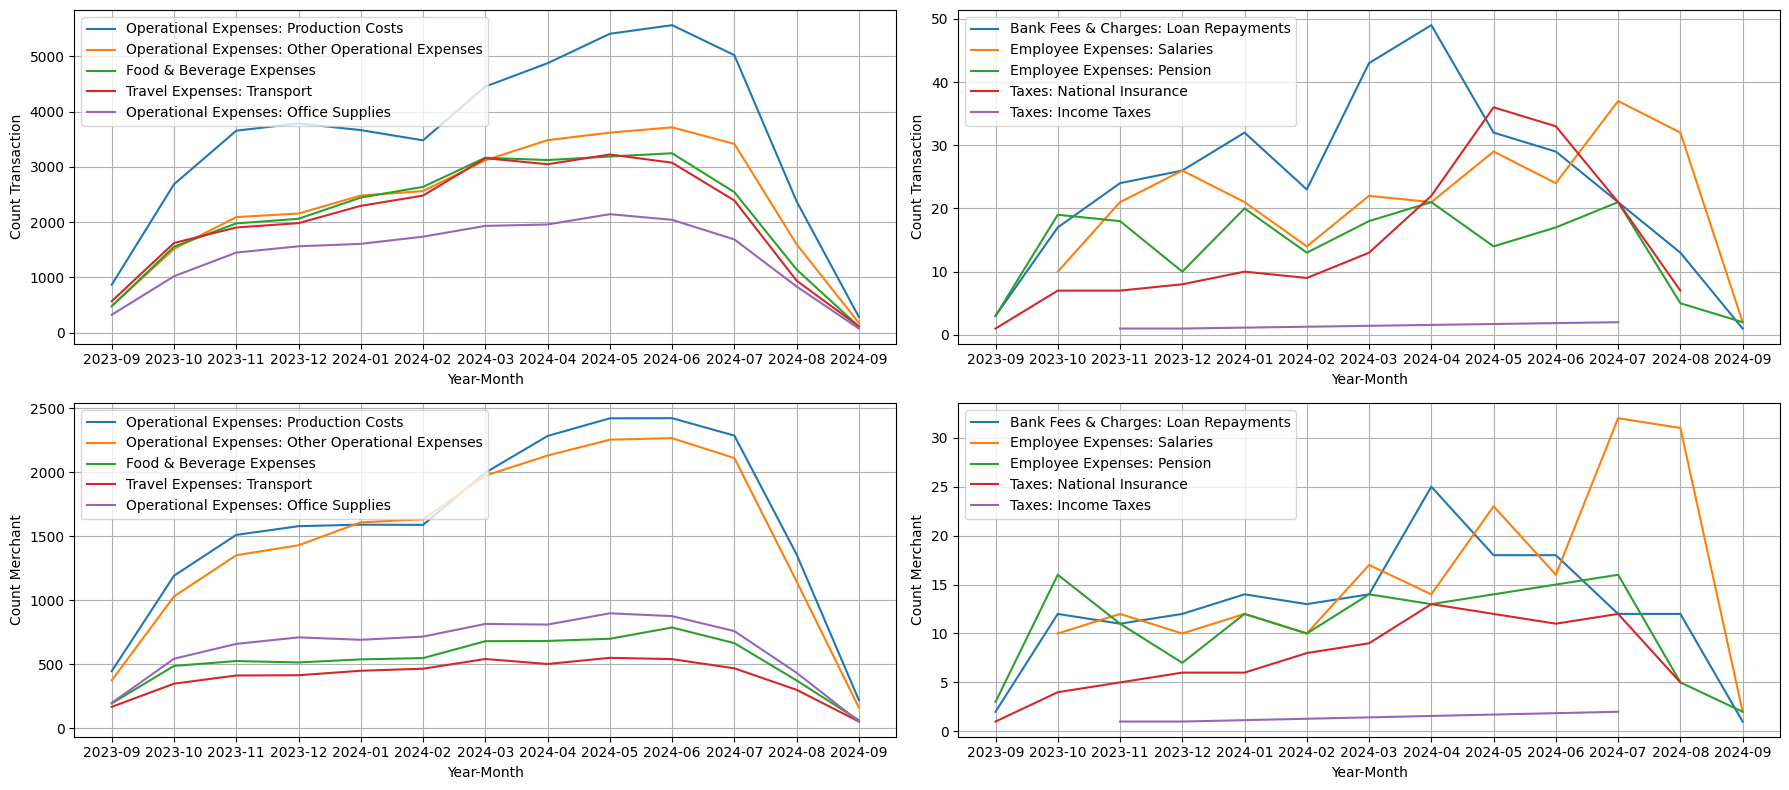

In [11]:
# Evolution of some categories (top 5 most frequent first column, top 5 least frequent second column)

TOP_FLOP_5_CATEGORIES = [df.CATEGORY.value_counts().index[:5], df.CATEGORY.value_counts().index[-5:]]
df['YEAR_MONTH'] = df.DATE_EMITTED.dt.to_period('M')
index = 0

fig, ax = plt.subplots(2,2, figsize=(18, 8))
for CATEGORIES in TOP_FLOP_5_CATEGORIES:
    for CATEGORY in CATEGORIES:
        tmp = df[df.CATEGORY == CATEGORY]
        df_grouped_by_year_month = tmp\
            .groupby(['YEAR_MONTH'])\
            .agg(
                {'TRANSACTION_ID': pd.Series.nunique, 
                  'CATEGORY': pd.Series.nunique, 
                  'TYPE_OF_PAYMENT': pd.Series.nunique, 
                  'MERCHANT_NAME': pd.Series.nunique
                })\
            .rename(columns={'TRANSACTION_ID': 'COUNT_TRANSACTION_ID', 'MERCHANT_NAME': 'COUNT_MERCHANT_NAME'})\
            .reset_index()
    
        ax[0, index].plot(df_grouped_by_year_month['YEAR_MONTH'].astype(str), df_grouped_by_year_month['COUNT_TRANSACTION_ID']) 
        ax[0, index].grid(True)
        ax[1, index].plot(df_grouped_by_year_month['YEAR_MONTH'].astype(str), df_grouped_by_year_month['COUNT_MERCHANT_NAME']) 
        ax[1, index].grid(True)
    ax[0, index].set_xlabel('Year-Month'), ax[1, index].set_xlabel('Year-Month')
    ax[0, index].set_ylabel('Count Transaction'), ax[1, index].set_ylabel('Count Merchant')
    ax[0, index].legend(CATEGORIES), ax[1, index].legend(CATEGORIES)
    index+=1

plt.tight_layout()

### 6. Feature selection and conclusion

In [12]:
id_transaction = ["TRANSACTION_ID"]
date_variables = ["DATE_EMITTED"]
categorial_variables = ["TYPE_OF_PAYMENT", "MERCHANT_NAME", "DESCRIPTION", "SIDE"]
numerical_variables = ['AMOUNT']
target = ["CATEGORY"]


**Excluded Features:**

- TRANSACTION_ID - Correctly excluded as it's a unique identifier with no predictive power for category classification
- DATE_EMITTED - Generally excluded, though you note it could potentially help predict the 4 least frequent categories that don't occur in certain months (seasonal patterns)
- SIDE - Excluded because analysis shows it contains only one category, making it uninformative for classification

**Selected Features for Model:**
- Based on your analysis, the remaining features for category prediction would be: `["TYPE_OF_PAYMENT", "MERCHANT_NAME", "DESCRIPTION", "AMOUNT"]`
- target = ["CATEGORY"]

**Justification for Selected Features:**
- `TYPE_OF_PAYMENT` - Different payment methods correlate with specific expense categories
- `MERCHANT_NAME` - Strong predictor as specific merchants typically provide consistent service types 
- `DESCRIPTION` - Contains textual information that can reveal category through keywords and transaction details
- `AMOUNT` - Transaction amounts often have characteristic ranges for different expense categories

**Additional Considerations:**

- `DATE_EMITTED` could be reconsidered if seasonal patterns are important for your business model
- Feature engineering from `DESCRIPTION` (text preprocessing, keyword extraction) may improve model performance
- `MERCHANT_NAME` might benefit from grouping/clustering similar merchants to reduce cardinality

This feature selection follows good ML practices by removing non-informative variables while retaining those with clear predictive potential for expense categorization.